# Alps, Himalayas or Rocky Mountains?

In [1]:
from fastai.vision import *

### Creating maps for picture to be downloaded

In [17]:
folder = 'alps'
file = 'alps.txt'

In [21]:
folder = 'rocky_mountains'
file = 'rocky_mountains.txt'

In [26]:
folder = 'himalayas'
file = 'himalayas.txt'

In [2]:
path = Path('data/mountains')

In [27]:
#path = Path('data/mountains')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('data/mountains/alps'),
 PosixPath('data/mountains/himalayas'),
 PosixPath('data/mountains/rocky_mountains'),
 PosixPath('data/mountains/models')]

### Downloading images

In [5]:
classes = ['alps', 'rocky_mountains', 'himalayas']

In [28]:
download_images(path/folder/file, dest, max_pics=200)

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

### Randomly assigning 20% of the dataset for training.

In [43]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [44]:
data.classes

['alps', 'himalayas', 'rocky_mountains']

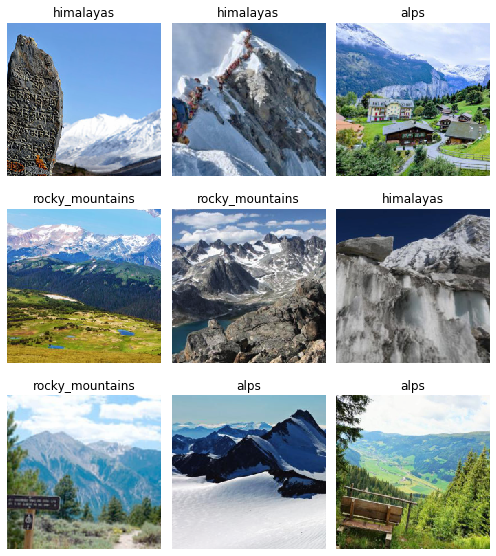

In [45]:
data.show_batch(rows=3, figsize=(7,8))

In [46]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['alps', 'himalayas', 'rocky_mountains'], 3, 229, 57)

### Training

In [47]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [48]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.386480,1.129528,0.684211,00:03
1,1.254022,0.881584,0.350877,00:03
2,1.103593,0.879180,0.385965,00:03
3,1.001114,0.873664,0.333333,00:03
4,0.940601,0.877056,0.315789,00:03
5,0.877198,0.895089,0.333333,00:03


In [49]:
learn.save('stage-4')

In [50]:
learn.unfreeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


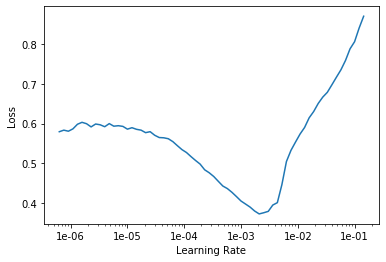

In [52]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(3, max_lr=slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.132712,0.802362,0.228070,00:03
1,0.111743,0.781787,0.245614,00:03
2,0.095390,0.762163,0.245614,00:03


In [56]:
learn.save('stage-5')

### Interpretation

In [57]:
learn.load('stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (229 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
alps,alps,alps,alps,alps
Path: data/mountains;

Valid: LabelList (57 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
alps,rocky_mountains,himalayas,rocky_mountains,rocky_mountains
Path: data/mountains;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

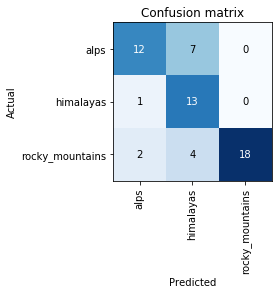

In [60]:
interp.plot_confusion_matrix()

### Cleaning up the data

In [61]:
from fastai.widgets import *

In [62]:
db = (ImageList.from_folder(path)
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch())

In [66]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-5');

### Creating indices for misclassified images

In [67]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

### This fella creates .csv file for changes to be applied (or not) to the dataset

In [68]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [41]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [42]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())